# Kohonen Self Organized Maps For Learning MNIST
This post consists of:

1. Kohonen Train and Test
    1. Libraries
    2. Data
    3. Kohonen Implementation
    4. Experiments
        1. 30x30
        2. 10x10
        3. 5x5
        3. 10x1
        4. 100x1
2. Answer These questions
    1. What is your approach for calculating accuracy?
    2. What is best model for this task?
    3. Do we have same number of neurons for each cluster?

### 1 Kohonen Train and Test
1. Libraries
2. Data
3. Kohonen Implementation
4. Experiments
    1. 30x30
    2. 10x10
    3. 5x5
    3. 10x1
    4. 100x1

#### 1.1 Libraries

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import cv2

%matplotlib inline

#### 1.2 Data

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='data')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
def split(x, y, normalize=True, resize=None)
    if resize is not None:
        data = np.empty((mnist.data.shape[0], resize))
        for idx, im in enumerate(mnist.data):
            data[idx] = cv2.resize(im.reshape(28, 28), resize, cv2.INTER_AREA).flatten()
    if normalize:
        data = scale(mnist.data)  # normalization
    x_train, x_test, y_train, y_test = train_test_split(data, mnist.target, train_size=50000)
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    return x_train, y_train, x_test, y_test

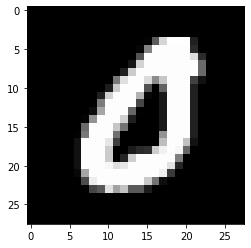

In [213]:
plt.imshow(mnist.data[0].reshape(28, 28), cmap='gray')
print(y_train[0])

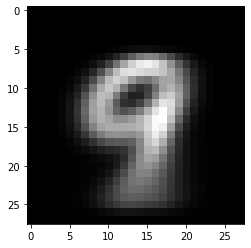

In [231]:
def get_avg(x, y):
    avgs = []
    for i in range(10):
        m = x[y==i].mean(axis=0)
        avgs.append(m)
    return avgs
centroids = get_avg(mnist.data, mnist.target)
plt.imshow(centroids[9].reshape(28,28), cmap='gray')

#### 1.3 Kohonen Implementation

In [ ]:
class Kohonen:
    # initialization
    def __init__(self, m, n, model=None, net_dim=(30, 30), learning_rate=0.5, iterations=100, n_classes = 10):
        if model is None:
            model = np.random.random((net_dim[0], net_dim[1], m))*0.01
        self.model = model
        self.net_dim = net_dim
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.init_radius = np.average(np.array(net_dim)) / 2
        self.m = m
        self.n = n
        self.n_classes = n_classes
        self.time_constant = iterations / np.log(self.init_radius)
        self.labels = np.zeros((self.model.shape[0], self.model.shape[1], self.n_classes))

    # competition
    def fittest_neuron(self, feature):
        """
        Finds fittest neuron w.r.t. given input features x and model

        :return: the neuron and its index in model.
        """
        # calculate the distance between each neuron and the input using vectorized operation
        distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
        pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        return (self.model[pos], pos)
    
    # Cooperation
    def decay_radius(self, i):
        return self.init_radius * np.exp(-i / self.time_constant)

    def decay_learning_rate(self, i):
        return self.learning_rate * np.exp(-i / self.iterations)

    # gaussian neighboring
    def h(self, distance, radius):
        return np.exp(-distance / (2* (radius**2)))

    # Adaption
    def train(self, x_train):
        zx = np.arange(0, self.net_dim[0], 1)
        zy = np.arange(0, self.net_dim[1], 1)
        zx, zy = np.meshgrid(zx,zy, indexing='ij')
        mesh_init = np.array([zx, zy])

        for i in range(self.iterations):
            # sample = x_train[np.random.randint(0, n, 1)]
            for feature in x_train:

                # find the fittest
                fittest, fittest_idx = self.fittest_neuron(feature)
            
                # decay the SOM parameters
                r = self.decay_radius(i)
                l = self.decay_learning_rate(i)
            
                # update weight vector
                mesh_init[0] = mesh_init[0] - fittest_idx[0]
                mesh_init[1] = mesh_init[1] - fittest_idx[1]
                mesh = np.sqrt(np.sum(mesh_init ** 2, axis=0))
                neighbor_mask = mesh < r
                if len(neighbor_mask.flatten()) > 0:
                    mesh[neighbor_mask] = self.h(mesh[neighbor_mask], r)
                    self.model[neighbor_mask] = self.model[neighbor_mask] + l * np.multiply(mesh[neighbor_mask][:, np.newaxis], (feature - self.model)[neighbor_mask])   
    
    def error(self, x):
        distances = np.empty((x.shape[0],))
        for idx, feature in enumerate(x):
            fittest, fittest_idx = self.fittest_neuron(feature)
            distances[idx] = ((fittest - feature) ** 2).sum()
        return distances.mean()

    def label_neurons(self, x_train, y_train):
        # majority vote on reiterating train data and labeling winner node
        for idx, feature in enumerate(x_train):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            self.labels[pos[0], pos[1], y_train[idx]] += 1
        self.labels = np.argmax(self.labels, axis=2)
        return self.labels

    def accuracy(self, x_test, y_test):
        t = 0
        for idx, feature in enumerate(x_test):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            if self.labels[pos[0], pos[1]] == y_test[idx]:
                t += 1
        return t / len(y_test)

    def visualize_map(self, x_test, y_test):
        wmap = {}
        im = 0
        for x, t in zip(x_test[:1000], y_test[:1000]):
            distance = np.sqrt(np.sum((self.model - x) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            wmap[pos] = im
            plt.text(pos[0],  pos[1],  str(t), color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
            im = im + 1
        plt.axis([0, self.model.shape[0], 0,  self.model.shape[1]])
        plt.show()

#### 1.4 Experiments
1. 30x30
2. 10x10
3. 5x5
4. 10x1
4. 100x1

Note: all printed **accuracy** values has been optained on **test set**.

##### 1.4.1 30x30 Kohonen (Best model)

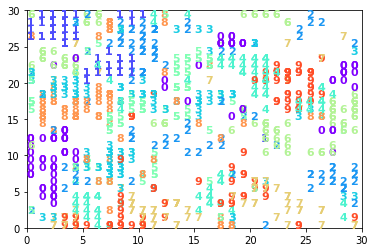

accuracy 0.82505


(array([134.,  41., 130.,  93.,  90.,  84.,  96., 103.,  63.,  66.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

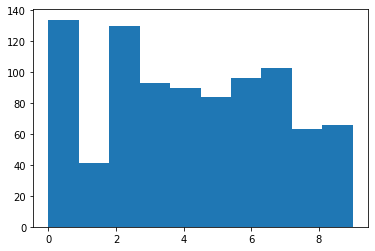

In [409]:
n = x_train.shape[0]  # samples
m = x_train.shape[1]  # features
kohonen30x30 = Kohonen(m=m, n=n, net_dim=(30, 30))
kohonen30x30.train(x_train)
# I could not hold the ouput of iteration as I saved model using pickle and trained for more than 1000 iterations but final weights are saved as
# it took more than 15 hours( I am not sure though)
kohonen30x30.visualize_map(x_test, y_test)
kohonen30x30.label_neurons(x_train, y_train)
print('accuracy', kohonen30x30.accuracy(x_test, y_test))
plt.hist(kohonen30x30.labels.flatten(), bins=10)

##### 1.4.2 10x10 Kohonen

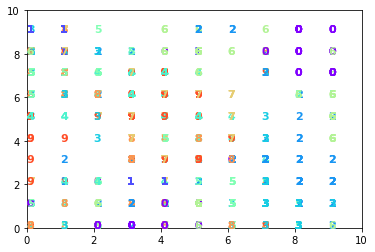

accuracy 0.6884


(array([11.,  4., 16.,  9.,  7., 11., 14., 12.,  9.,  7.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

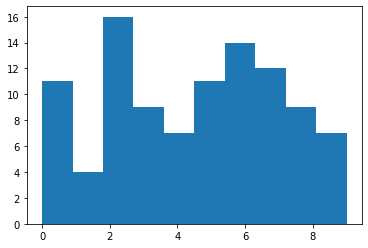

In [411]:
n = x_train.shape[0]  # samples
m = x_train.shape[1]  # features
kohonen10x10 = Kohonen(m=m, n=n, net_dim=(10, 10))
kohonen10x10.train(x_train)
kohonen10x10.visualize_map(x_test, y_test)
kohonen10x10.label_neurons(x_train, y_train)
print('accuracy',kohonen10x10.accuracy(x_test, y_test))
plt.hist(kohonen10x10.labels.flatten(), bins=10)

##### 1.4.3 5x5 Kohonen

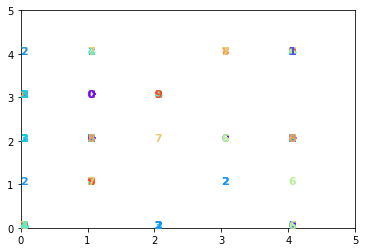

accuracy 0.42635


(array([1., 1., 8., 3., 1., 1., 5., 3., 0., 2.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

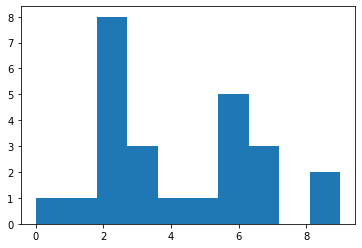

In [414]:
n = x_train.shape[0]  # samples
m = x_train.shape[1]  # features
kohonen5x5 = Kohonen(m=m, n=n, net_dim=(5, 5))
kohonen5x5.train(x_train)
kohonen5x5.visualize_map(x_test, y_test)
kohonen5x5.label_neurons(x_train, y_train)
print('accuracy',kohonen5x5.accuracy(x_test, y_test))
plt.hist(kohonen5x5.labels.flatten(), bins=10)

##### 1.4.4 10x1 Kohonen

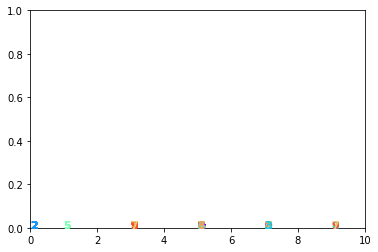

accuracy 0.16565


(array([1., 2., 1., 0., 0., 1., 2., 2., 0., 1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

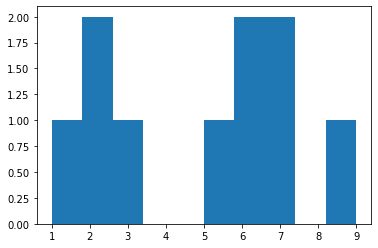

In [417]:
n = x_train.shape[0]  # samples
m = x_train.shape[1]  # features
kohonen10x1 = Kohonen(m=m, n=n, net_dim=(10, 1))
kohonen10x1.train(x_train)
kohonen10x1.visualize_map(x_test, y_test)
kohonen10x1.label_neurons(x_train, y_train)
print('accuracy',kohonen10x1.accuracy(x_test, y_test))
plt.hist(kohonen10x1.labels.flatten(), bins=10)

##### 1.4.5 100x1 Kohonen

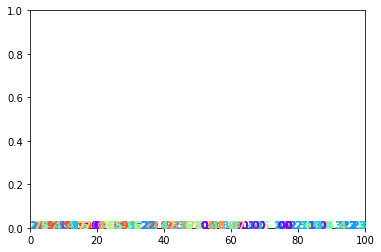

accuracy 0.70955


(array([12.,  2., 14., 13.,  7., 11., 11., 11., 10.,  9.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

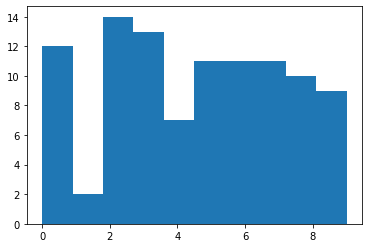

In [419]:
n = x_train.shape[0]  # samples
m = x_train.shape[1]  # features
kohonen100x1 = Kohonen(m=m, n=n, net_dim=(100, 1))
kohonen100x1.train(x_train)
kohonen100x1.visualize_map(x_test, y_test)
kohonen100x1.label_neurons(x_train, y_train)
print('accuracy',kohonen100x1.accuracy(x_test, y_test))
plt.hist(kohonen100x1.labels.flatten(), bins=10)

In [ ]:
import pickle
pickle.dump((kohonen30x30), open('kohonen30x30_best.model', 'wb'))
pickle.dump((kohonen10x10), open('kohonen10x10_best.model', 'wb'))

### 2 Answer These questions
1. What is your approach for calculating accuracy?
2. What is best model for this task?
3. Do we have same number of neurons for each cluster?

#### 2.1 Accuracy Calculation

The approach I have used has been proposed by Prof. Kohonen in his book called *Self-Organizing Maps-Springer-Verlag Berlin Heidelberg (2001) - page 314*. In this approach after converging using available data, we pass the data one more iteration through the network but this time we freeze the weights and just label each winner neuron with the label of given entry of our data. But I have extended it and used *majority vote* which means I have counted how many times each class for each neuron has been selected so we have a historgram of data that vote for each class in each neuron. Then I took max over this vector to label the neuron.

#### 2.2 Best Model Architecture
There are two famous approach for deciding number of neurons for given dataset.

1. `10 * number_of_classes`: This approach says we need about 10 neuron per class on average. We can see the result of this idea in *100x1* network which we have introduced 10 neurons per class in 1D manner. Achieved accuracy on test set is `0.71` which is good.

2. `sqrt(5 * sqrt(len(dataset)))`: Second approach is based on the dataset size. in our case it outputs *33.3* which in 2D manner I have used *30x30* 2D Kohonen which gave `0.825` accuracy on test which is really good; Almost same result with a MLP with 1 hidden layer and 1024 hidden neurons for 300 epochs using gradient descent optimizer.

In [340]:
n_classes = 10
10*n_classes

100

In [339]:
np.sqrt(5*np.sqrt(x_train.shape[0]))

33.437015248821105

#### 2.3 Number of Neuron Regarding Clusters

We can analyze this topic in below manners:

1. The number of samples in each class is important which defnes the density of features in feature space, so more samples needs more candidates to be represented.

2. Other factor is the distribution of the features of each class (cluster). For instance, consider gaussian distribution regarding different sigma values, narrower one can be expressed in a small area of kohonen map which means less number of neurons and vice versa.

As an example, we can see in 30x30 and 100x1 models, `0` needed much more number of neurons in relation to `1` and the reason is that even though `1` has more samples (but not much, almost same with `0`), but the complexity of images of `1` sample are much less than `0`. We can approve this idea by observing the Kohonen map of 30x30 which `1` samples are in a small area while `0`s have 3 cluster  spread all over the map.

In [338]:
for i in range(10):
    m = mnist.data[mnist.target==i].__len__()
    print('class "{}" => #{} samples'.format(i, m))

class "0" => #6903 samples
class "1" => #7877 samples
class "2" => #6990 samples
class "3" => #7141 samples
class "4" => #6824 samples
class "5" => #6313 samples
class "6" => #6876 samples
class "7" => #7293 samples
class "8" => #6825 samples
class "9" => #6958 samples
